In [23]:
import datetime

import praw
import pandas as pd


from keys import client_id, client_secret

### Data Extration

Calling the reddit api to scrap comment from a thread

In [24]:
reddit = praw.Reddit( client_id=client_id,
                      client_secret=client_secret,
                      user_agent='android:my_app:v1 (by /u/ben_110)')
submission = reddit.submission(url="https://www.reddit.com/r/newzealand/comments/i7oi7e/coronavirus_new_positive_case_with_no_history_of/")
submission.comments.replace_more(limit=None)
post = []
for comment in submission.comments.list():
    post.append([comment.body])
    
""" building a data frame and exporting to post.csv"""
df = pd.DataFrame(post, columns=["text"])
df= df.iloc[1:] #first post is a sticky post
df.to_csv('posts.csv', index=False)

### Cleaning data

In [25]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk import bigrams
import nltk.corpus as corpus
import tokenize
stopwords = stopwords.words("english")

df.dropna(subset=["text"], inplace=True)
df.text = df.text.apply(lambda x: re.sub(r"[^\w\s]", "", x))                                                                            #removing new line characters and space
df.text = df.text.apply(lambda x: re.sub(r"\(?http\S+", "", x))                                                                         #removing links
df.text = df.text.apply(lambda x: " ".join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))                  #removing stop words

lem = nltk.WordNetLemmatizer()
df.text = df.text.apply(lambda x:" ".join([lem.lemmatize(word) for word in nltk.word_tokenize(x)]))

### Bigrams

Creating a list of words

In [26]:
t_list = df.text.to_list()
bi_gram_list = list()
for item in t_list:
    temp_list = item.split()
    for item in temp_list:
        bi_gram_list.append(item)

In [27]:
bi_gram = nltk.collocations.BigramAssocMeasures()
finder =  BigramCollocationFinder.from_words(bi_gram_list)
finder.apply_freq_filter(10)
print(finder.nbest(bi_gram.pmi, 10))

[('Kia', 'kaha'), ('herd', 'immunity'), ('toilet', 'paper'), ('panic', 'buying'), ('gon', 'na'), ('second', 'wave'), ('Alert', 'Level'), ('social', 'distancing'), ('Good', 'luck'), ('mental', 'health')]


### WordCloud

In [28]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import random

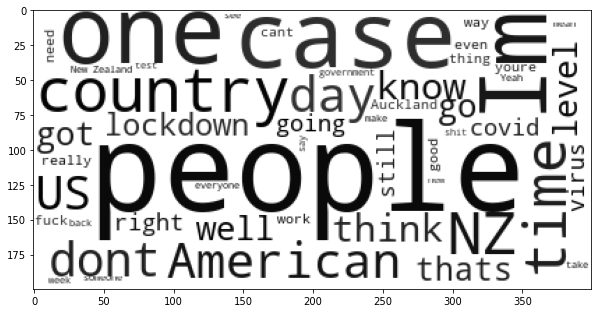

In [29]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)
wc_string = ", ".join(bi_gram_list)
stp = STOPWORDS.copy()
word_cloud = WordCloud(background_color="white", max_words=50,  stopwords=stp)
word_cloud.generate(wc_string)

plt.figure(figsize=(10,20))
plt.imshow(word_cloud.recolor(color_func=grey_color_func, random_state=3))
plt.show()

### Vador Analysis

In [85]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Z87-4770\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [134]:
sid = SentimentIntensityAnalyzer()
new_words = {
    "kia kaha": 50 #kia kaha is a maori word meaning "stay strong", it is unlikely Vador pakage would have this word.
}
sid.lexicon.update(new_words)
df[["negative", "neutural", "positive", "compound"]] = df.text.apply(lambda x: pd.Series(sid.polarity_scores(x)))

In [171]:
"""I have set the neutural score to between -0.3 and 0.3"""
df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c >=0.3 else ('neg' if c <=-0.3 else "neu"))

In [172]:
df.head()

,text,negative,neutural,positive,compound,comp_score
1,watching Quiet Place civil defence alert happe...,0.354,0.427,0.220,-0.4939,neg
2,Fighting covid like fighting fire respond mome...,0.369,0.546,0.085,-0.8074,neg
3,UkezzaNZ really appreciated prompt undates loc...,0.000,0.514,0.486,0.8840,pos
4,hello darkness old friend,0.278,0.278,0.444,0.2960,neu
5,Aw man work major supermarket distribution cen...,0.097,0.674,0.229,0.5473,pos


In [173]:
neu = 0
pos = 0
neg = 0
for item in df["comp_score"]:
    if item == "neg":
        neg += 1
    if item == "pos":
        pos += 1
    if item == "neu":
        neu += 1

[1187, 2431, 1482]


<BarContainer object of 3 artists>

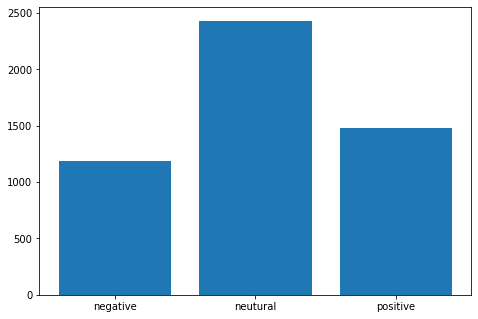

In [174]:
sentiment_count = [neg, neu, pos]
print(sentiment_count)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_axis = ["negative", "neutural", "positive"]
ax.bar(x_axis, sentiment_count)